# Deep Learning for Time Series Forecasting

This notebook is used for understanding deep learning applications to time series forecasting.

Reference: https://www.kaggle.com/code/dimitreoliveira/deep-learning-for-time-series-forecasting

Content:

* Time series visualizations
* Transform time series data to supervised learning
* Multi-layer perceptron
* Convolutional Neural Network
* Long Short-Term Memory network
* Hybrid CNN-LSTM


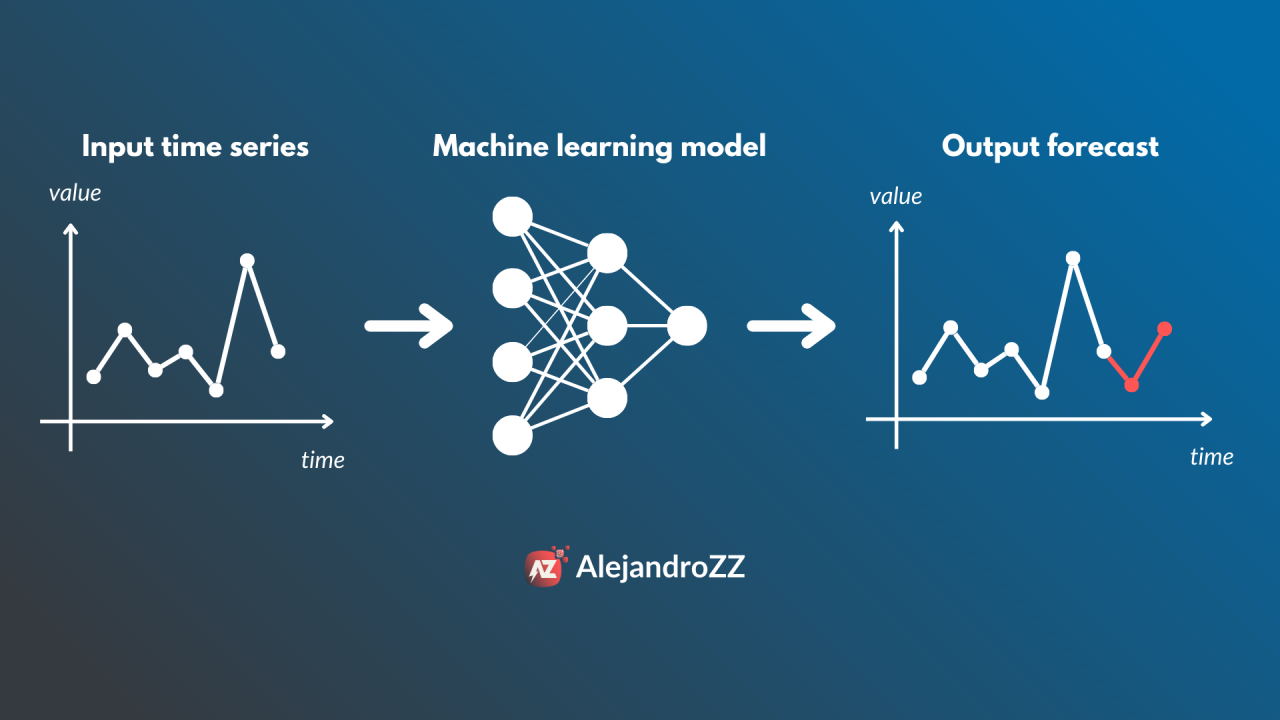

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

%matplotlib inline
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

from tensorflow import set_random_seed
from numpy.random import seed
set_random_seed(1)
seed(1)

Using TensorFlow backend.


## Download datasets

In [2]:
train_set = pd.read_csv('../input/demand-forecasting-kernels-only/train.csv', parse_dates=['date'])
test_set = pd.read_csv('../input/demand-forecasting-kernels-only/test.csv', parse_dates=['date'])

In [3]:
train_set.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [4]:
train_set.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


In [5]:
test_set.describe()

,id,store,item
count,45000.000000,45000.000000,45000.00000
mean,22499.500000,5.500000,25.50000
std,12990.525394,2.872313,14.43103
min,0.000000,1.000000,1.00000
25%,11249.750000,3.000000,13.00000
50%,22499.500000,5.500000,25.50000
75%,33749.250000,8.000000,38.00000
max,44999.000000,10.000000,50.00000


In [6]:
print("Min date from train set: ", train_set["date"].min().date())
print("Max date from train set: ", train_set["date"].max().date())

Min date from train set:  2013-01-01
Max date from train set:  2017-12-31


## Forecast time horizon 

The window to forecast seems to be 90 days from the datasets provided.

In [7]:
forecast_horizon = (test_set["date"].max().date() - train_set["date"].max().date()).days
print("Min date from train set: ", train_set["date"].min().date())
print("Max date from test set: ", test_set["date"].max().date())
print("Forecast horizon by number of days: ", forecast_horizon)

Min date from train set:  2013-01-01
Max date from test set:  2018-03-31
Forecast horizon by number of days:  90


## Explore Data

EDA on datasets

In [8]:
daily_transactions = train_set.groupby("date", as_index = False)["sales"].sum()
stores_daily_sales = train_set.groupby(["store", "date"], as_index = False)["sales"].sum()
item_daily_sales = train_set.groupby(["item", "date"], as_index = False)["sales"].sum()

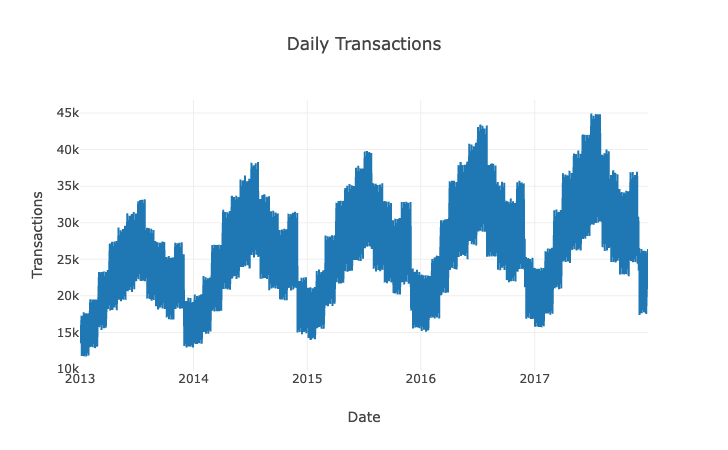

In [9]:
daily_transactions_scatter = go.Scatter(x = daily_transactions["date"], y = daily_transactions["sales"])
layout = go.Layout(title = "Daily Transactions", xaxis = dict(title = "Date"), yaxis = dict(title = "Transactions"))
figure = go.Figure(data = [daily_transactions_scatter], layout = layout)
iplot(figure)

# Daily transactions by store

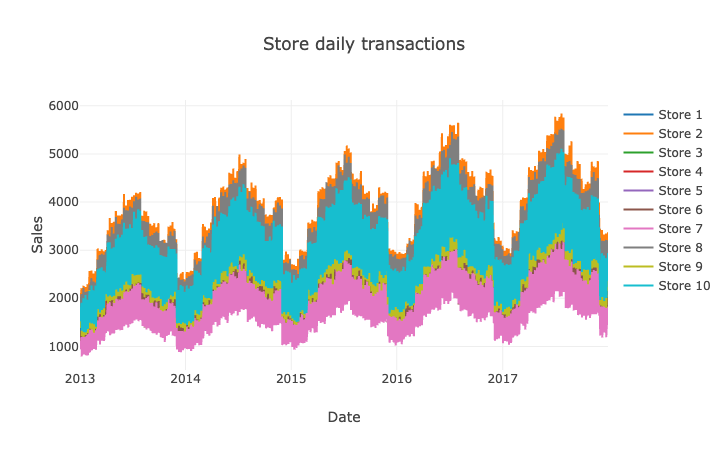

In [10]:
daily_sales_stores = []
for store in stores_daily_sales["store"].unique():
    current_store = stores_daily_sales[(stores_daily_sales["store"] == store)]
    daily_sales_stores.append(go.Scatter(x = current_store["date"], y = current_store["sales"], name=('Store %s' % store) ))
lay = go.Layout(title = "Store daily transactions", xaxis = dict(title = "Date"), yaxis = dict(title = "Sales"))
figure = go.Figure(data = daily_sales_stores, layout = lay)
iplot(figure)

## Sample of training set

We can take a sample of the training dataset, get the last one year of data to reduce training time and inference times for a quick baseline

In [11]:
train_sample = train_set[train_set["date"] >= "2017-01-01"]
train_sample.head()

,date,store,item,sales
1461,2017-01-01,1,1,19
1462,2017-01-02,1,1,15
1463,2017-01-03,1,1,10
1464,2017-01-04,1,1,16
1465,2017-01-05,1,1,14


In [12]:
print("Size of train sample for last year: ", len(train_sample))

Size of train sample for last year:  182500


## Transform the data into a time series problem

In [13]:
def convert_to_time_series(data, window = 1, lag = 1, dropnan = True):
    cols, names = list(), list()
    # Input (t - n, ... t - 1)
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [14]:
window = 29
lag_size = 1
lag = lag_size
series = convert_to_time_series(train_sample.drop('date', axis=1), window=window, lag=lag)
series.head()

,store(t-29),item(t-29),sales(t-29),store(t-28),item(t-28),sales(t-28),store(t-27),item(t-27),sales(t-27),store(t-26),item(t-26),sales(t-26),store(t-25),item(t-25),sales(t-25),store(t-24),item(t-24),sales(t-24),store(t-23),item(t-23),sales(t-23),store(t-22),item(t-22),sales(t-22),store(t-21),item(t-21),sales(t-21),store(t-20),item(t-20),sales(t-20),store(t-19),item(t-19),sales(t-19),store(t-18),item(t-18),sales(t-18),store(t-17),item(t-17),sales(t-17),store(t-16),...,sales(t-12),store(t-11),item(t-11),sales(t-11),store(t-10),item(t-10),sales(t-10),store(t-9),item(t-9),sales(t-9),store(t-8),item(t-8),sales(t-8),store(t-7),item(t-7),sales(t-7),store(t-6),item(t-6),sales(t-6),store(t-5),item(t-5),sales(t-5),store(t-4),item(t-4),sales(t-4),store(t-3),item(t-3),sales(t-3),store(t-2),item(t-2),sales(t-2),store(t-1),item(t-1),sales(t-1),store(t),item(t),sales(t),store(t+1),item(t+1),sales(t+1)
1490,1.0,1.0,19.0,1.0,1.0,15.0,1.0,1.0,10.0,1.0,1.0,16.0,1.0,1.0,14.0,1.0,1.0,24.0,1.0,1.0,14.0,1.0,1.0,20.0,1.0,1.0,18.0,1.0,1.0,11.0,1.0,1.0,14.0,1.0,1.0,17.0,1.0,1.0,7.0,1.0,...,10.0,1.0,1.0,16.0,1.0,1.0,22.0,1.0,1.0,13.0,1.0,1.0,21.0,1.0,1.0,9.0,1.0,1.0,18.0,1.0,1.0,14.0,1.0,1.0,13.0,1.0,1.0,10.0,1.0,1.0,16.0,1.0,1.0,24.0,1,1,9,1.0,1.0,17.0
1491,1.0,1.0,15.0,1.0,1.0,10.0,1.0,1.0,16.0,1.0,1.0,14.0,1.0,1.0,24.0,1.0,1.0,14.0,1.0,1.0,20.0,1.0,1.0,18.0,1.0,1.0,11.0,1.0,1.0,14.0,1.0,1.0,17.0,1.0,1.0,7.0,1.0,1.0,16.0,1.0,...,16.0,1.0,1.0,22.0,1.0,1.0,13.0,1.0,1.0,21.0,1.0,1.0,9.0,1.0,1.0,18.0,1.0,1.0,14.0,1.0,1.0,13.0,1.0,1.0,10.0,1.0,1.0,16.0,1.0,1.0,24.0,1.0,1.0,9.0,1,1,17,1.0,1.0,15.0
1492,1.0,1.0,10.0,1.0,1.0,16.0,1.0,1.0,14.0,1.0,1.0,24.0,1.0,1.0,14.0,1.0,1.0,20.0,1.0,1.0,18.0,1.0,1.0,11.0,1.0,1.0,14.0,1.0,1.0,17.0,1.0,1.0,7.0,1.0,1.0,16.0,1.0,1.0,29.0,1.0,...,22.0,1.0,1.0,13.0,1.0,1.0,21.0,1.0,1.0,9.0,1.0,1.0,18.0,1.0,1.0,14.0,1.0,1.0,13.0,1.0,1.0,10.0,1.0,1.0,16.0,1.0,1.0,24.0,1.0,1.0,9.0,1.0,1.0,17.0,1,1,15,1.0,1.0,17.0
1493,1.0,1.0,16.0,1.0,1.0,14.0,1.0,1.0,24.0,1.0,1.0,14.0,1.0,1.0,20.0,1.0,1.0,18.0,1.0,1.0,11.0,1.0,1.0,14.0,1.0,1.0,17.0,1.0,1.0,7.0,1.0,1.0,16.0,1.0,1.0,29.0,1.0,1.0,15.0,1.0,...,13.0,1.0,1.0,21.0,1.0,1.0,9.0,1.0,1.0,18.0,1.0,1.0,14.0,1.0,1.0,13.0,1.0,1.0,10.0,1.0,1.0,16.0,1.0,1.0,24.0,1.0,1.0,9.0,1.0,1.0,17.0,1.0,1.0,15.0,1,1,17,1.0,1.0,24.0
1494,1.0,1.0,14.0,1.0,1.0,24.0,1.0,1.0,14.0,1.0,1.0,20.0,1.0,1.0,18.0,1.0,1.0,11.0,1.0,1.0,14.0,1.0,1.0,17.0,1.0,1.0,7.0,1.0,1.0,16.0,1.0,1.0,29.0,1.0,1.0,15.0,1.0,1.0,14.0,1.0,...,21.0,1.0,1.0,9.0,1.0,1.0,18.0,1.0,1.0,14.0,1.0,1.0,13.0,1.0,1.0,10.0,1.0,1.0,16.0,1.0,1.0,24.0,1.0,1.0,9.0,1.0,1.0,17.0,1.0,1.0,15.0,1.0,1.0,17.0,1,1,24,1.0,1.0,25.0


In [15]:
last_item = 'item(t-%d)' % window
last_store = 'store(t-%d)' % window
series = series[(series['store(t)'] == series[last_store])]
series = series[(series['item(t)'] == series[last_item])]

In [16]:
columns_to_drop = [('%s(t+%d)' % (col, lag)) for col in ['item', 'store']]
for i in range(window, 0, -1):
    columns_to_drop += [('%s(t-%d)' % (col, i)) for col in ['item', 'store']]
series.drop(columns_to_drop, axis=1, inplace=True)
series.drop(['item(t)', 'store(t)'], axis=1, inplace=True)

## Train validation split

In [17]:
labels_col = "sales(t+%d)" % lag_size
labels = series[labels_col]
series = series.drop(labels_col, axis=1)

X_train, X_valid, Y_train, Y_valid = train_test_split(series, labels.values, test_size=0.2, random_state=0)
print('Train set shape', X_train.shape)
print('Validation set shape', X_valid.shape)
X_train.head()

Train set shape (134399, 30)
Validation set shape (33600, 30)


,sales(t-29),sales(t-28),sales(t-27),sales(t-26),sales(t-25),sales(t-24),sales(t-23),sales(t-22),sales(t-21),sales(t-20),sales(t-19),sales(t-18),sales(t-17),sales(t-16),sales(t-15),sales(t-14),sales(t-13),sales(t-12),sales(t-11),sales(t-10),sales(t-9),sales(t-8),sales(t-7),sales(t-6),sales(t-5),sales(t-4),sales(t-3),sales(t-2),sales(t-1),sales(t)
558547,42.0,44.0,51.0,66.0,63.0,59.0,71.0,42.0,61.0,60.0,53.0,50.0,58.0,66.0,58.0,52.0,48.0,50.0,63.0,69.0,66.0,52.0,58.0,54.0,50.0,72.0,67.0,70.0,52.0,55
7013,18.0,20.0,15.0,17.0,25.0,10.0,18.0,16.0,24.0,16.0,18.0,26.0,12.0,13.0,20.0,22.0,28.0,20.0,23.0,21.0,13.0,28.0,18.0,29.0,16.0,27.0,16.0,28.0,21.0,22
605948,22.0,24.0,38.0,37.0,29.0,16.0,18.0,35.0,33.0,37.0,46.0,33.0,29.0,42.0,36.0,32.0,31.0,39.0,33.0,24.0,42.0,26.0,49.0,38.0,28.0,34.0,23.0,34.0,28.0,27
744857,31.0,36.0,52.0,51.0,40.0,35.0,33.0,36.0,37.0,33.0,36.0,46.0,30.0,32.0,32.0,35.0,40.0,39.0,44.0,35.0,41.0,42.0,34.0,27.0,53.0,31.0,44.0,26.0,24.0,40
219050,127.0,67.0,85.0,71.0,94.0,95.0,111.0,90.0,67.0,74.0,82.0,96.0,77.0,94.0,111.0,61.0,90.0,74.0,82.0,102.0,126.0,112.0,73.0,96.0,95.0,80.0,101.0,84.0,109.0,67


## MLP for Time Series Forecasting

Using a basic multi-layered perceptron. Does not take into account sequenced data, will not detect patterns in sequences.

In [18]:
epochs = 50
batch = 256
lr = 0.0005
adam = optimizers.Adam(lr)

In [19]:
mlp = Sequential()
mlp.add(Dense(100, activation="relu", input_dim = X_train.shape[1]))
mlp.add(Dense(1))
mlp.compile(loss = "mse", optimizer = adam)
mlp.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               3100      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 3,201
Trainable params: 3,201
Non-trainable params: 0
_________________________________________________________________


## CNN for Time Series Forecasting

Two convolutional layers hidden layers followed by a max pooling layer. Hidden layers should be able to discern patterns through the time series. 

In [20]:
X_train_cnn_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_cnn_series = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))

In [21]:
cnn = Sequential()
cnn.add(Conv1D(filters = 64, kernel_size = 2, activation = "relu", input_shape = (X_train_cnn_series.shape[1], X_train_cnn_series.shape[2])))
cnn.add(Conv1D(filters = 128, kernel_size = 2, activation = "relu", input_shape = (X_train_cnn_series.shape[1], X_train_cnn_series.shape[2])))
cnn.add(MaxPooling1D(pool_size = 2))
cnn.add(Flatten())
cnn.add(Dense(50, activation = "relu"))
cnn.add(Dense(1))
cnn.compile(loss = "mse", optimizer = adam)
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 29, 64)            192       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 28, 128)           16512     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 14, 128)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1792)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                89650     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total params: 106,405
Trainable params: 106,405
Non-trainable params: 0
_________________________________________________________________


In [22]:
cnn_history = cnn.fit(X_train_cnn_series, Y_train, validation_data = (X_valid_cnn_series, Y_valid), epochs = epochs, verbose = 2)

Train on 134399 samples, validate on 33600 samples
Epoch 1/50
 - 19s - loss: 96.2175 - val_loss: 84.2387
Epoch 2/50
 - 13s - loss: 85.3396 - val_loss: 98.6470
Epoch 3/50
 - 12s - loss: 83.2001 - val_loss: 80.5831
Epoch 4/50
 - 13s - loss: 81.7542 - val_loss: 79.4499
Epoch 5/50
 - 12s - loss: 80.9196 - val_loss: 81.6424
Epoch 6/50
 - 12s - loss: 80.8304 - val_loss: 78.3194
Epoch 7/50
 - 13s - loss: 80.3546 - val_loss: 78.3954
Epoch 8/50
 - 12s - loss: 80.1562 - val_loss: 78.7153
Epoch 9/50
 - 13s - loss: 79.7021 - val_loss: 78.6745
Epoch 10/50
 - 12s - loss: 79.6247 - val_loss: 80.0874
Epoch 11/50
 - 13s - loss: 79.5577 - val_loss: 79.1993
Epoch 12/50
 - 12s - loss: 79.2389 - val_loss: 78.5757
Epoch 13/50
 - 12s - loss: 79.2737 - val_loss: 77.8863
Epoch 14/50
 - 13s - loss: 79.0040 - val_loss: 80.7125
Epoch 15/50
 - 12s - loss: 78.8116 - val_loss: 79.1811
Epoch 16/50
 - 12s - loss: 78.6297 - val_loss: 77.7204
Epoch 17/50
 - 13s - loss: 78.5469 - val_loss: 77.8342
Epoch 18/50
 - 12s - lo

## LSTM for Time Series Forecasting

We can use a LSTM model which see's the data as a sequence. It also has memory cells to learn from patterns in the sequenced data.

In [23]:
lstm = Sequential()
lstm.add(LSTM(50, activation = "relu", input_shape = (X_train_cnn_series.shape[1], X_train_cnn_series.shape[2])))
lstm.add(Dense(1))
lstm.compile(loss = "mse", optimizer = adam)
lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                10400     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [24]:
lstm_history = lstm.fit(X_train_cnn_series, Y_train, validation_data= (X_valid_cnn_series, Y_valid), epochs = 20, verbose = 2)

Train on 134399 samples, validate on 33600 samples
Epoch 1/20
 - 163s - loss: 344.0945 - val_loss: 121.8224
Epoch 2/20
 - 160s - loss: 135.4211 - val_loss: 102.4844
Epoch 3/20
 - 160s - loss: 101.3091 - val_loss: 97.9773
Epoch 4/20
 - 159s - loss: 94.2700 - val_loss: 88.9956
Epoch 5/20
 - 159s - loss: 90.8175 - val_loss: 85.7008
Epoch 6/20
 - 161s - loss: 93.3060 - val_loss: 85.9075
Epoch 7/20
 - 159s - loss: 89.9360 - val_loss: 86.9957
Epoch 8/20
 - 159s - loss: 88.0934 - val_loss: 85.0566
Epoch 9/20
 - 159s - loss: 87.7945 - val_loss: 83.2956
Epoch 10/20
 - 159s - loss: 122.3538 - val_loss: 125.4643
Epoch 11/20
 - 159s - loss: 113.4221 - val_loss: 108.3553
Epoch 12/20
 - 159s - loss: 95.1609 - val_loss: 87.7621
Epoch 13/20
 - 159s - loss: 89.7780 - val_loss: 85.6365
Epoch 14/20
 - 159s - loss: 90.0303 - val_loss: 89.1758
Epoch 15/20
 - 158s - loss: 88.2145 - val_loss: 83.0643
Epoch 16/20
 - 159s - loss: 10005.4557 - val_loss: 209.1731
Epoch 17/20
 - 158s - loss: 1095.8458 - val_loss:

## CNN-LSTM for Time Series Forecasting

This model benefits with supporting very long input sequences that can be read as blocks. We can divide the model with two subsequences of two times per subequence. The CNN model will discern patterns in the sub sequences and the LSTM will piece together the patterns from the subsequences.


In [34]:
X_train, X_valid, Y_train, Y_valid = train_test_split(series, labels.values, test_size=0.4, random_state=0)
print('Train set shape', X_train.shape)
print('Validation set shape', X_valid.shape)

Train set shape (100799, 30)
Validation set shape (67200, 30)


In [35]:
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))

In [46]:
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (100799, 30, 1)
Validation set shape (67200, 30, 1)


In [37]:
subseq = 2
timesteps = X_train_series.shape[1] // subseq
X_train_cnn_series_sub = X_train_series.reshape((X_train_series.shape[0], subseq, timesteps, 1))
X_valid_cnn_series_sub = X_valid_series.reshape((X_valid_series.shape[0], subsequences, timesteps, 1))

In [45]:
print('Train set shape', X_train_cnn_series_sub.shape)
print('Validation set shape', X_valid_cnn_series_sub.shape)

Train set shape (100799, 2, 15, 1)
Validation set shape (67200, 2, 15, 1)


In [40]:
cnn_lstm = Sequential()
cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, X_train_cnn_series_sub.shape[2], X_train_cnn_series_sub.shape[3])))
cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size = 2)))
cnn_lstm.add(TimeDistributed((Flatten())))
cnn_lstm.add(LSTM(50, activation = "relu"))
cnn_lstm.add(Dense(1))
cnn_lstm.compile(loss = "mse", optimizer = adam)

In [47]:
cnn_lstm_history = cnn_lstm.fit(X_train_cnn_series_sub, Y_train, validation_data=(X_valid_cnn_series_sub, Y_valid), epochs=10, verbose=2)

Train on 100799 samples, validate on 67200 samples
Epoch 1/10
 - 20s - loss: 123.6241 - val_loss: 108.8939
Epoch 2/10
 - 19s - loss: 108.9420 - val_loss: 110.0445
Epoch 3/10
 - 19s - loss: 107.5674 - val_loss: 104.6371
Epoch 4/10
 - 19s - loss: 107.4233 - val_loss: 107.6708
Epoch 5/10
 - 19s - loss: 106.8254 - val_loss: 103.0353
Epoch 6/10
 - 19s - loss: 106.1747 - val_loss: 102.9062
Epoch 7/10
 - 19s - loss: 105.3315 - val_loss: 102.2130
Epoch 8/10
 - 19s - loss: 103.9615 - val_loss: 101.9728
Epoch 9/10
 - 19s - loss: 102.9220 - val_loss: 100.9168
Epoch 10/10
 - 19s - loss: 102.4488 - val_loss: 100.0507


## Metrics

Scores for all models 

In [56]:
mlp_training_pred = mlp.predict(X_train.values)
mlp_validation_pred = mlp.predict(X_valid.values)
print('Train rmse:', round(np.sqrt(mean_squared_error(Y_train, mlp_training_pred))))
print('Validation rmse:', round(np.sqrt(mean_squared_error(Y_valid, mlp_validation_pred))))

Train rmse: 39.0
Validation rmse: 39.0


In [57]:
cnn_train_pred = cnn.predict(X_train_series)
cnn_valid_pred = cnn.predict(X_valid_series)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, cnn_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, cnn_valid_pred)))

Train rmse: 8.883456133433684
Validation rmse: 8.908523341412456


In [58]:
lstm_train_pred = lstm.predict(X_train_series)
lstm_valid_pred = cnn.predict(X_valid_series)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, lstm_valid_pred)))

Train rmse: 10.916901132925796
Validation rmse: 8.908523341412456


In [60]:
cnn_lstm_train_pred = cnn_lstm.predict(X_train_cnn_series_sub)
cnn_lstm_valid_pred = cnn_lstm.predict(X_valid_cnn_series_sub)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, cnn_lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, cnn_lstm_valid_pred)))

Train rmse: 10.041831247266087
Validation rmse: 10.002533362884199
